## Perturbed Pendulum: Non-Reversible SympNet

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
import time
import wandb
import os
from matplotlib import rc

### Import Training Dataset

In [14]:
file = open("x_train_PPH_Asym.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()


Nlines = int(line_count/2)

u0 = []

prova = open("x_train_PPH_Asym.txt", "r")
for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    u0.append(np.array([x,y]))
prova.close()

T = []

prova = open("y_train_PPH_Asym.txt", "r")

for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    T.append(np.array([x,y]))
prova.close()

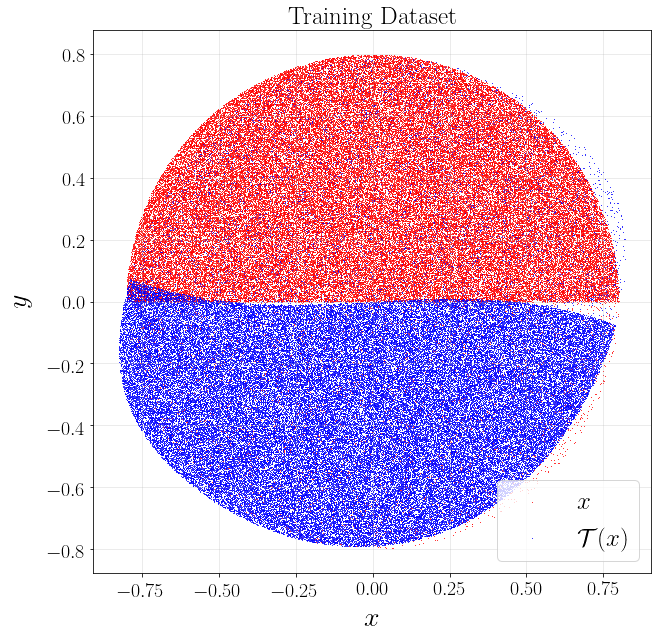

In [15]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Training Dataset', fontsize = 25)
plt.scatter([u0[i][0] for i in range(len(u0))], [u0[i][1] for i in range(len(u0))], label = r'$x$', linewidth = 0, color ='r', s=1)
plt.scatter([T[i][0] for i in range(len(u0))], [T[i][1] for i in range(len(u0))], label = r'$\mathcal{T}(x)$', linewidth = 0, color = 'b', s=1)
plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)
#plt.savefig("DoublePendulum_Example")
plt.show()

### Training Dataset

In [17]:
x_train = np.array(u0)
x_train = x_train.astype(np.float32)

y_train = np.array(T)
y_train = y_train.astype(np.float32)



x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(10000)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(10000)

train_dataset.element_spec

(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

-------------------------------
-------------------------------
-------------------------------

### Custom Layers

In [18]:
class linear_module_up(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )
    
        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(2,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0.])

    def call(self, x):
        
        L = tf.concat([[[1., self.w[0]]],[[0., 1.]]], 0)
        return tf.linalg.matvec(L, x) + self.b


class linear_module_low(layers.Layer):
    
    def __init__(self, bias):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )

        if bias==1:
            self.b = self.add_weight(
            name='b',
            shape=(2,),
            initializer = 'random_normal',
            trainable = True
            )
            
        else:
            self.b = tf.constant([0., 0.])

    def call(self, x):
        
        L = tf.concat([[[1., 0.]],[[self.w[0], 1.]]], 0)
        return tf.linalg.matvec(L,x) + self.b


    

class activation_module_up(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):        
        t = tf.concat([[[0., self.w[0]]], [[0.,0.]]], 0)
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

class activation_module_low(layers.Layer):
    
    def __init__(self):
        
        super().__init__()
        self.w = self.add_weight(
        name='w',
        shape=(1,),
        initializer = 'random_normal',
        trainable = True
        )


    def call(self, x):
        t = tf.concat([[[0., 0.]], [[self.w[0], 0.]]], 0)        
        return x + tf.linalg.matvec(t, tf.math.tanh(x))

### SympNet

In [19]:
class SympNet(keras.Model):
    
    def __init__(self, N_layers, N_sub):
        
        super().__init__()
        
        
        self.Modules = []
        
        for i in range(N_layers):
            
            if i%2==0:
                self.Modules.append(activation_module_up())
                
            else:
                self.Modules.append(activation_module_low())
                
            for j in range(N_sub):
                
                if j==(N_sub-1):
                    bias = 1
                else:
                    bias = 0
                
                if j%2==0:
                    self.Modules.append(linear_module_up(bias))

                else:
                    self.Modules.append(linear_module_low(bias))
        
        

    def call(self, input_tensor):
        
        boom = self.Modules[0](input_tensor)
        
        for i in range(1,len(self.Modules)):
            boom = self.Modules[i](boom)
        
        #for i in range(1, len(self.Modules)):
        #    boom = self.Modules[-i](boom)
        
        #boom = self.Modules[0](boom)
    
        return boom

In [ ]:
model = SympNet(15, 7)

## Training

In [ ]:
# DECAYING LEARNING RATE

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr*tf.math.exp(-0.001)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [ ]:
#wandb.init()
start_time = time.time()
history = model.fit(train_dataset, epochs = 10, validation_data=val_dataset, callbacks=[callback], verbose=1)
print("running time : %s seconds" % (time.time() - start_time))

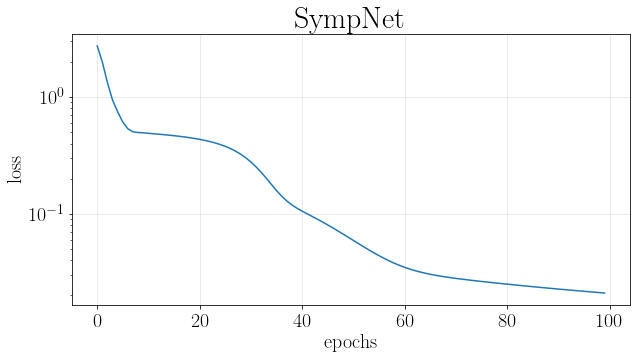

In [11]:
plt.figure(figsize = (10,5))
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

### Export the training and validation loss

In [16]:
os.remove("Loss1.txt")
f = open("Loss1.txt", "a")
for i in history.history["loss"]:
    f.write(str(i))
    f.write("\n")
f.close()

os.remove("Val1.txt")
f = open("Val1.txt", "a")
for i in history.history["val_loss"]:
    f.write(str(i))
    f.write("\n")
f.close()

## Tests

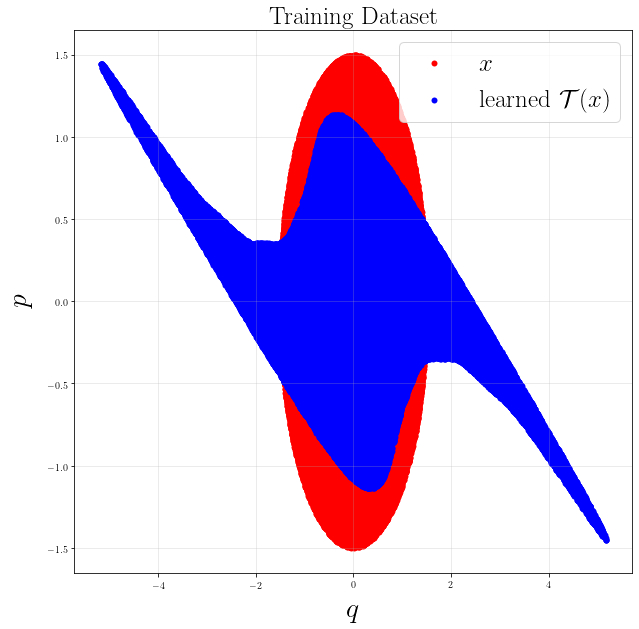

In [70]:
u = model(x_train)

Nplot = Nlines

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 25)
plt.scatter([x_train[i][0] for i in range(len(x_train))], [x_train[i][1] for i in range(len(x_train))], label = r'$x$', linewidth = 0, color ='r', s=1)
plt.scatter([T[i][0] for i in range(len(x_train))], [T[i][1] for i in range(len(x_train))], label = r'$\mathcal{T}(x)$', linewidth = 0, color ='b', s=1)
plt.scatter([u[i][0].numpy() for i in range(len(x_train))], [u[i][1].numpy() for i in range(len(x_train))], label = r'$\hat{\mathcal{T}}(x)$', linewidth = 0, color ='g', s=1)
plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)
#plt.savefig("DoublePendulum_Example")
plt.show()

### True Poincare Plot

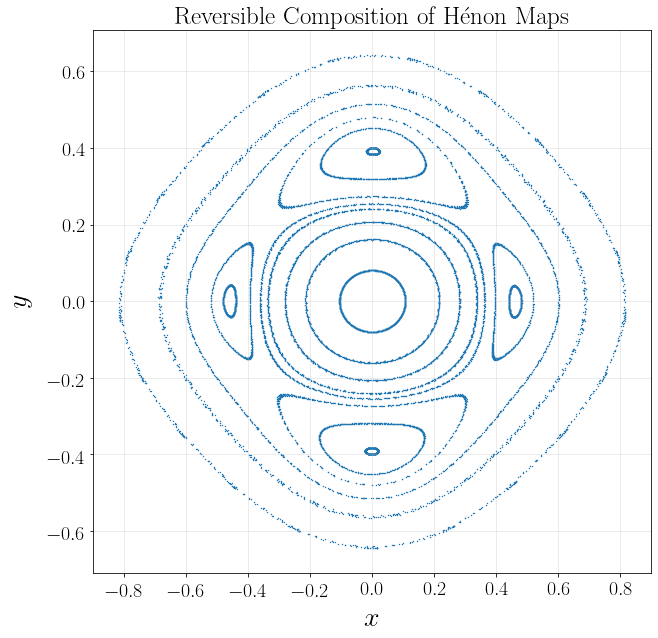

In [3]:
file = open("Poincare.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()


Nlines = int(line_count/2)

Poincare_points = []

prova = open("Poincare.txt", "r")
for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    Poincare_points.append(np.array([x,y]))
prova.close()

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 25)

plt.scatter([i[0] for i in Poincare_points], [i[1] for i in Poincare_points], linewidth = 0, s=2)

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.show()

### Iterations

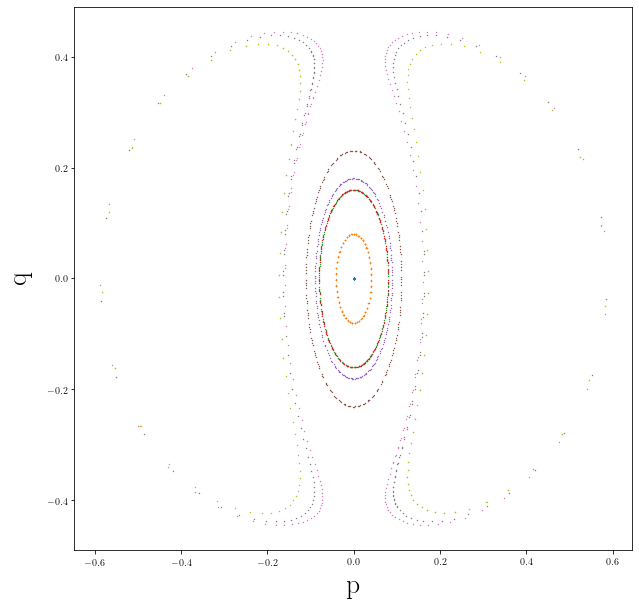

In [113]:
x0 = np.array([[0.0, 0.1],[0.0, 0.2],[0.0, 0.3],[0.0, 0.4],[0.0, 0.5],[0.0, 0.6],[0.1, 0.],[0.2, 0.],[0.3, 0.],[0.4, 0.],[0.5, 0.]])

iterations = [model(x0)]
for _ in range(200):
    iterations.append(model(iterations[-1]))

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 25)

for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0)
    
plt.scatter(*zip(*x0.numpy()), s=15, linewidth=0)

plt.scatter([i[0] for i in Poincare_points], [i[1] for i in Poincare_points], linewidth = 0, s=2)

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.show()

### Reversibility

In [ ]:
x0 = np.array([[rd.randrange(250, 300, 1)*0.001, rd.randrange(250, 300, 1)*0.001] for _ in range(100)])

f_iterations = [model(x0)]
for _ in range(100):
    f_iterations.append(model(f_iterations[-1]))

b_iterations = [f_iterations[-1]*np.array([[1., -1.]])]
for _ in range(100):
    b_iterations.append(model(b_iterations[-1]))

In [ ]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 25)


plt.scatter(*zip(*f_iterations[0].numpy()), s=1, linewidth=0, color='r', label= r'$\hat{\mathcal{T}}^{n}[X_{0}] \qquad n=1,\dots ,100$')

for i in f_iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color='r')
    
#plt.scatter(*zip(*f_iterations[-1].numpy()), s=15, linewidth=0, color='r')

#plt.scatter(*zip(*b_iterations[0].numpy()), s=15, linewidth=0, color='b')

b_iterations_symm = b_iterations*np.array([[1., -1.]])

plt.scatter(*zip(*b_iterations_symm[0]), s=1, linewidth=0, color='b', label= r'$R \hat{\mathcal{T}}^{n}[R(\hat{\mathcal{T}}^{100}(X_{0}))] \qquad n=1,\dots 100$')

for i in b_iterations_symm:
    plt.scatter(*zip(*i), s=1, linewidth=0, color='b')

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(scatterpoints=1, fontsize=25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
#plt.savefig("Testing_Reversinility_NonReversible.png")
plt.show()

### Quantitative Test for Reversibility

In [ ]:
A = np.array(f_iterations)
B = np.flip(b_iterations_symm, 0)

(np.square(A - B)).mean(axis=None)

---------------------------------
---------------------------------
---------------------------------

### Three iterations Poincare plot

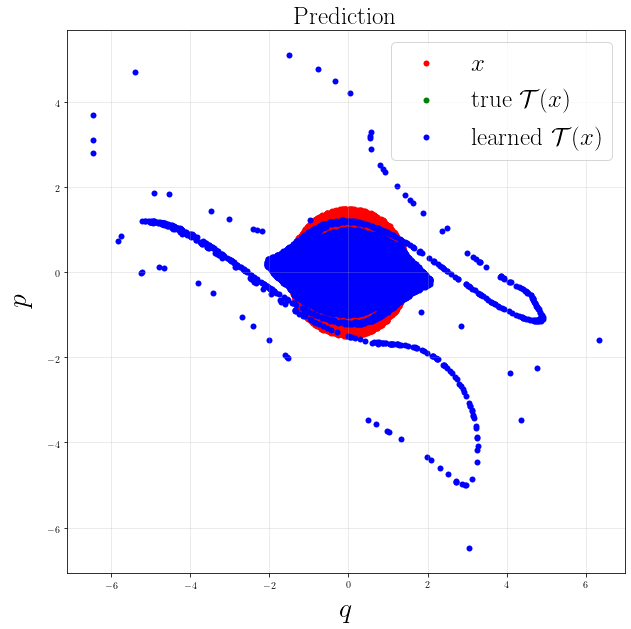

In [269]:
file = open("x_train_PPH_2iter.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()


Nlines = int(line_count/2)

u0 = []

prova = open("x_train_PPH_2iter.txt", "r")
for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    u0.append(np.array([x,y]))
prova.close()

T = []

prova = open("y_train_PPH_2iter.txt", "r")

for i in range(Nlines):
    x = float(prova.readline())
    y = float(prova.readline())
    T.append(np.array([x,y]))
prova.close()



u = model(x_train)
u = model(u)

Nplot = 10000

plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Prediction', fontsize = 25)
plt.scatter([x_train[i][0] for i in range(Nplot)], [x_train[i][1] for i in range(Nplot)], label = r'$x$', linewidth = 0, color ='r')
plt.scatter([T[i][0] for i in range(len(u0))], [T[i][1] for i in range(len(u0))], label = r'true $\mathcal{T}(x)$', linewidth = 0, color = 'g')
plt.scatter([u[i][0].numpy() for i in range(Nplot)], [u[i][1].numpy() for i in range(Nplot)], label = r'learned $\mathcal{T}(x)$', linewidth = 0, color ='b')
plt.xlabel(r'$q$', fontsize=28, labelpad=8)
plt.ylabel(r'$p$', fontsize=28, labelpad=15)
plt.grid(axis='both', alpha=.3)
plt.legend(fontsize = 25)

#plt.savefig("DoublePendulum_Example")

plt.show()